## AF3Plot
Plotting MSA, pLDDT, and PAE output from the new AlphaFold3 server

_Note: This notebook is under active testing. I have no idea how DeepMind have structured the data within the .json files, so bare with._

### 1. Importing dependencies

In [1]:
import json
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### 2. Sorting through output folder files
The folder should contain something like this:

|&#128193; | | | |
|---------------------|--------------------|----------------------|---------------------|
|fold_[...]_full_data_0.json         |fold_[...]_full_data_1.json        |fold_[...]_full_data_2.json          |fold_[...]_full_data_3.json  |
|fold_[...]_full_data_4.json  |fold_[...]_job_request.json  |fold_[...]_model_0.cif          |fold_[...]_model_1.cif|
|fold_[...]_model_2.cif                 |fold_[...]_model_3.cif       |fold_[...]_model_4.cif    |fold_[...]_summary_confidences_0.json  |
|fold_[...]_summary_confidences_1.json   |fold_[...]_summary_confidences_2.json  |fold_[...]_summary_confidences_3.json |fold_[...]_summary_confidences_4.json|
|terms_of_use.md         |

In [2]:
class ARG:
    def __init__(self, repo):
        self.input_dir = repo
        self.output_dir = repo
        self.name = name 

repo = [input('Please copy the path to your output folder (e.g. /User/Documents/fold_2024__05_12_protein1 ): ')] # This is a list of all output repositories
name = input('Please enter your AlphaFold3 job name (e.g. 2024-05-22_protein1): ')
name = name.replace('-','_')

### 3. Loading JSON files into Jupyter

In [16]:
# Option 1: json.load
for r in repo:
    args = ARG(r)
    summary_confidences=[]
    full_data=[]
    for i in range(0,5,1):
        with open(os.path.join(r, "fold_"+name+"_summary_confidences_"+str(i)+".json")) as scFile:
            sc = json.load(scFile)
            summary_confidences.append(sc)
        with open(os.path.join(r, "fold_"+name+"_full_data_"+str(i)+".json")) as fdFile:
            fd = json.load(fdFile)
            full_data.append(fd)

In [23]:
summary_confidences[0].keys()

dict_keys(['chain_iptm', 'chain_pair_iptm', 'chain_pair_pae_min', 'chain_ptm', 'fraction_disordered', 'has_clash', 'iptm', 'num_recycles', 'ptm', 'ranking_score'])

In [24]:
full_data[0].keys()

dict_keys(['atom_chain_ids', 'atom_plddts', 'contact_probs', 'pae', 'token_chain_ids', 'token_res_ids'])

### Structure of JSON files:

#### full_data

dict_keys(['atom_chain_ids', 'atom_plddts', 'contact_probs', 'pae', 'token_chain_ids', 'token_res_ids'])

My assessment of these values (will look into AF3 documentation to confirm)
- atom_chain_ids = Which chain (protein, ion, ligand etc) the atoms belong to ; format = 'A', 'B', 'C' ...
- atom_plddts = predicted local distance difference test score, _per atom_ (note: AF2 recorded these _per residue_) ; format = 0.00-100.00
- contact_probs = Probability of the atom making contact with another chain? ; format = 0.00-1.00
- pae = Predicted aligned error _per residue or ion?_ ; format = 0.00 upt0 >30.00 (Ångströms)
- token_chain_ids = Similar to atom_chain_ids, but _per residue or ion?_ ; format = 'A', 'B', 'C' ...
- token_res_ids = Position (residue) numbers ; format 1-(total number of residues)

In [51]:
len(full_data[0]['token_res_ids'])

3583

### Plotting the _per atom_ pLDDT

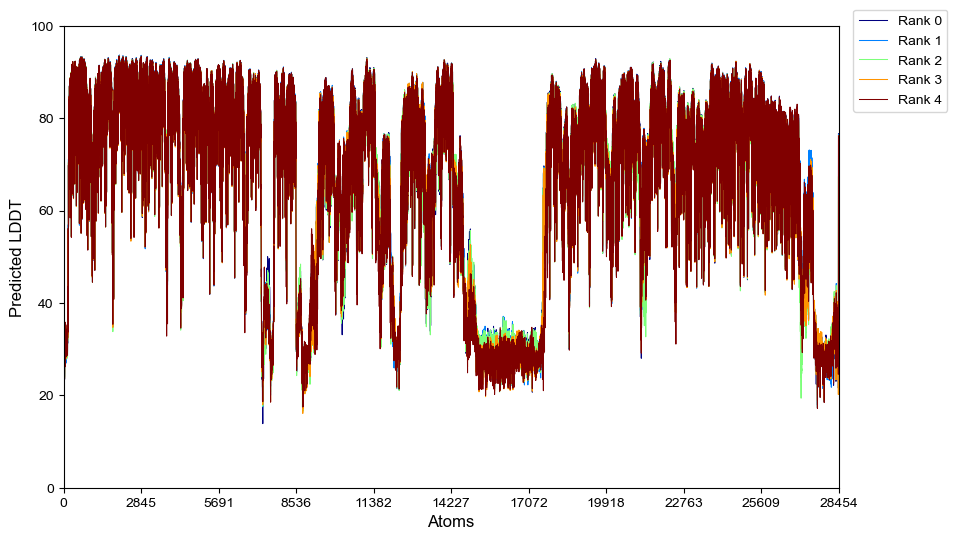

In [88]:
plot_param = 'atom_plddts'
# Plotting top-ranked prediction pLDDT scores
max_rank = input('How many of the top-ranked predictions would you like to plot? ')
if max_rank == '':
    rank_range = np.arange(0,5,1)
    NUM_COLORS = 5
else:
    rank_range = np.arange(0,int(max_rank),1)
    NUM_COLORS = int(max_rank)
#cm = plt.get_cmap('gist_rainbow') #color option 1
#cm = sns.color_palette('husl', n_colors = NUM_COLORS) #color option 2
cm = plt.cm.jet(np.linspace(0,1,NUM_COLORS)) #color option 3

fig, ax = plt.subplots(figsize=(10,6))
# Set fontface
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams["mathtext.default"] = "regular"
# Set colours
#matplotlib.rcParams['axes.prop_cycle'] = 
#ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
for i in rank_range:
    ax.plot(full_data[i][plot_param], label='Rank '+str(i), color=cm[i], linewidth=.75)

ax.set_ylabel('Predicted LDDT', fontsize=12)
ax.set_xlabel('Atoms', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1.05))
#ax.xaxis.set_major_locator(plt.MaxNLocator(df_xy.shape[0]/))
ax.set_ylim(top=100)
#xrange = input('What range of residues do you want to plot (e.g. "0-100" – leave blank for all): ')
#if xrange == '':
xmin, xmax = 0, len(full_data[i][plot_param])
#else:
    #xrng = xrange.split('-')
    #xmin, xmax = int(xrng[0]), int(xrng[1])

#horizLine = input('Plot a vertical divider? (y/n)')
#if horizLine == 'y':
    #ax.axvline(int(input('Which position? ')), color='gray', linestyle='--')

ax.set_xlim(xmin,xmax)
ax.set_ylim(0,100)
ax.set_xticks(np.round(np.linspace(xmin, xmax, 11), 2));
#1103.5
##outpath = csv_path.replace(filename,'')
#plt.savefig(f"{outpath}plddt-replot.pdf")   #<-- Remove #'s on this line to automatically save the figure as .pdf

### Plotting the Predicted Aligned Error (PAE)

/var/folders/nj/syftthh54r3fxf68spnr9r9c0000gn/T/ipykernel_58326/124856863.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_xticklabels([0,10,20,30],fontsize=8);


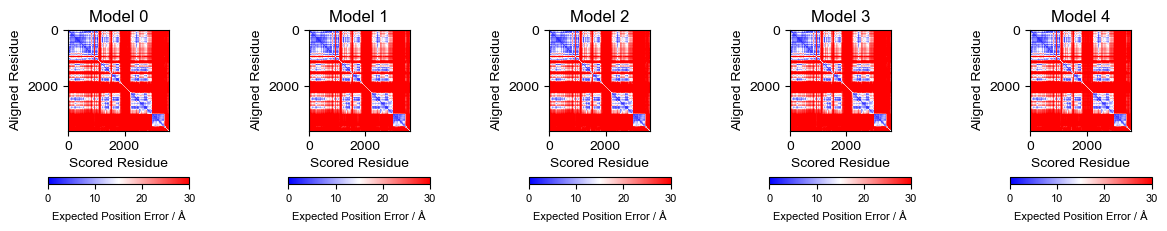

In [87]:
################# PLOT THE PREDICTED ALIGNED ERROR################
num_models = len(full_data)
plt.figure(figsize=(3 * num_models, 2), dpi=100)


for i in range(0,num_models,1):
    plt.subplot(1, num_models, i + 1)
    plt.title(f"Model {i}")
    #if max(full_data[i]['pae'])>=30:
    #    vmax = max(full_data[i]['pae']) 
    #else:
    #    vmax=30
    plt.imshow(full_data[i]['pae'], label=f"Model_{i}", cmap="bwr", vmin=0, vmax=30)
    plt.xlabel("Scored Residue", fontsize=10)
    #plt.set_tickparams(fontsize=8)
    plt.ylabel("Aligned Residue", fontsize=10)
    cbar = plt.colorbar(orientation="horizontal",fraction=0.046, pad=.3)
    cbar.ax.set_xlabel('Expected Position Error / Å', fontsize=8)
    cbar.ax.set_xticklabels([0,10,20,30],fontsize=8);
    #plt.tight_layout()

------------------------

#### Ignore below:

In [15]:
# Option 2: pandas.read_json NOT WORKING FOR THIS FILE FORMAT
for r in repo:
    args = ARG(r)
    summary_confidences=[]
    full_data=[]
    for i in range(0,5,1):
        sc = pd.read_json(os.path.join(r, "fold_"+name+"_summary_confidences_"+str(i)+".json"))
        summary_confidences.append(sc)
        fd = pd.read_json(os.path.join(r, "fold_"+name+"_full_data_"+str(i)+".json"))
        full_data.append(fd)

ValueError: All arrays must be of the same length